# Initialization

In [1]:
import os
import torch, pyro, numpy as np 

# from clipppy.globals import register_globals # Can just be commented out, doesn't work with new version of Clipppy, but didn't do anything in this notebook already.
from clipppy import load_config
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5))

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# register_globals(**globals()) # clipppy magic

In [2]:
# from plotting import plot_mult, test_import, test_import2
# import collections
# test_import(1)

def plot_mult(plots, nrows = 1, colorbar = False, size_x = 16, size_y = 8, cmap = [None]):
    """
    plots: list of what should be platted
    nrows: number of rows
    colobar: if True, a colorbar on each plot is plotted
    size_x, size_y: figsize = (size_x, size_y)
    """
    
    ncols = len(plots) // nrows
    N = len(plots)
    if len(cmap): cmap = cmap*N

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x, size_y))
    for ax, plot, i in zip(axes.flatten(), plots, range(N)):
        im = ax.imshow(plot, cmap = cmap[i])
        if colorbar == True:
            fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)
    plt.show()

### Load config

In [3]:
SYSTEM_NAME = "ngc4414"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME) # only used for saving
os.makedirs(BASEDIR, exist_ok=True) # only used for saving

In [4]:
SOURCE_DIR = '../../mock_data/sources'
source_name = f'{SYSTEM_NAME}.npy'

config = load_config('config_gen_mock.yaml', base_dir=SOURCE_DIR,
                     source_name=source_name) # clipppy magic

model = config.umodel # clippppy magic
guide = config.guide  # should play around with it

MASK = config.kwargs['defs']['mask']          # clipppy magic
NOISE = model.stochastic_specs['sigma_stat']  # noise is a spec of the stochastic process; clipppy magic
PARAMS = YAML().load(open('../paper-source/params.yaml'))[SYSTEM_NAME] # Real paramaters of system

/home/eliasd/lensing/clipppy/src/clipppy/yaml/constructor.py:55: FutureWarning: Using '__args' for parameter expansion is deprecated and will soon be considered an ordinary keyword argument. Consider using '<' instead.
  warn('Using \'__args\' for parameter expansion is deprecated'
/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:102: RuntimeWarning: Getting items from StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level that at most come from mappings (no dynamic generation).
  warn(f'Getting items from {type(self).__name__} by name is frowned upon'


In [5]:
# Only if we have the test 'config_gen_mock_test.yaml'
try:
    PARAMS['truth'] = collections.OrderedDict(config.kwargs['params']['truth'])
    print('Set other true params!')
except:
    pass

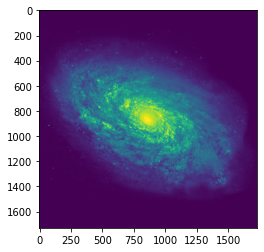

tensor(True)
1
ordereddict([('scale', 1.0), ('truth', ordereddict([('ext/gamma_1', 0.007), ('ext/gamma_2', 0.01), ('main/phi', 1.0), ('main/q', 0.75), ('main/r_ein', 1.5), ('main/slope', 2.1), ('main/x', -0.05), ('main/y', 0.1)])), ('init', ordereddict([('ext/gamma_1', 0.0), ('ext/gamma_2', 0.0), ('main/phi', 0.5), ('main/q', 0.5), ('main/r_ein', 1.42), ('main/slope', 2.0), ('main/x', 0.0), ('main/y', 0.0)]))])


In [6]:
plt.imshow(np.load(f'{SOURCE_DIR}/{source_name}'))
plt.show()

for i in [MASK, NOISE, PARAMS]:
    print(i)

# Generate mock data

#### Utilities

In [7]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import filters
from pyrofit.lensing.utils import Converter

def get_mask(img, sigma=1., th=1.):
    """
    Generate mask
    """
    smooth = filters.gaussian_filter(img.numpy(), sigma=sigma)
    return smooth > th

#### Set image as source

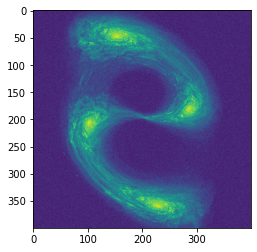

In [8]:
imgsrc = config.kwargs['defs']['imagesrc']
model.sources = {'image': imgsrc}

imgsrc

plt.imshow( model() )

#### True parameters for generating mock data

In [9]:
PARAMS['truth']

ordereddict([('ext/gamma_1', 0.007), ('ext/gamma_2', 0.01), ('main/phi', 1.0), ('main/q', 0.75), ('main/r_ein', 1.5), ('main/slope', 2.1), ('main/x', -0.05), ('main/y', 0.1)])

#### Generate a 10nx x 10ny mock image and downsample it to create a mock image

X: x-coord

Y: y-coord

model.mask: noise 

/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:113: RuntimeWarning: Setting items on StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level.
  warn(f'Setting items on {type(self).__name__} by name is frowned upon'


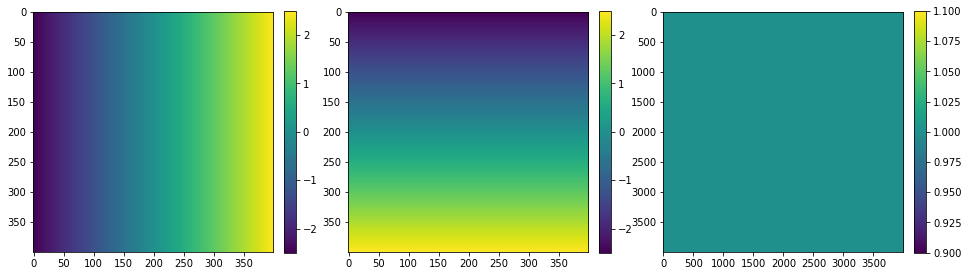

In [10]:
UPSAMPLE = 10

# Save final grid
X, Y = model.X.clone(), model.Y.clone()


model.coerce_XY(*get_meshgrid(
    config.kwargs["defs"]["res"] / UPSAMPLE,
    config.kwargs["defs"]["nx"] * UPSAMPLE,
    config.kwargs["defs"]["ny"] * UPSAMPLE
))
model.mask = torch.full_like(model.X, True, dtype=bool, device="cuda:0")
model.stochastic_specs['sigma_stat'] *= UPSAMPLE

plot_mult([X, Y, model.mask], 1, True)

In [11]:
# # parm_dict_upd = {'gamma_1' : 0.0443,
# #             'gamma_2' : 0.0069,
# #             'x' : -0.0102,
# #             'y' : 0.0202,
# #             'M' : 1e13,
# #             'c_200c' : 20,
# #             'tau' : 5}

# # PARAMS['truth'] = parm_dict_upd

# print("### PARAMS['truth'] ###")
# for k in PARAMS['truth']:
#     print(k, '\t', PARAMS['truth'][k])
# print('\n')


# print('### model ###')
# for lens in model.alphas.values(): # looping over ext and main
#     for spec in lens.stochastic_specs.values(): # looping over lens params
#         print(spec.name, '\t', spec.d)

# # plot_mult([model() for _ in range(3)], 1)
# plt.imshow(model(), **imkwargs)
# plt.colorbar()
# plt.show()

Ideally there should be **no** original image in the lensing. However, Noemi once read that physically there should *always* be one. (You better forget that last part)

In [12]:
# Sample from the model
with pyro.poutine.trace() as tracer, pyro.condition(data=PARAMS['truth']):
    OBS = model() # ???
OBSTRACE = tracer.trace

# Downsample observation
OBS = torch.tensor(downscale_local_mean(OBS, (UPSAMPLE, UPSAMPLE)))

# Downsample info from trace
data = dict(trace=OBSTRACE, obs=OBS, **{
    key: torch.tensor(downscale_local_mean(OBSTRACE.nodes[key]['value'], (UPSAMPLE, UPSAMPLE)))
    for key in ('mu', 'Xsrc', 'Ysrc')
})

In [13]:
dict(trace=OBSTRACE, obs=OBS, **{
    key: torch.tensor(downscale_local_mean(OBSTRACE.nodes[key]['value'], (UPSAMPLE, UPSAMPLE)))
    for key in ('mu', 'Xsrc', 'Ysrc')
})

{'trace': <pyro.poutine.trace_struct.Trace at 0x15243aacec40>,
 'obs': tensor([[-1.2422e+00,  8.5863e-01, -3.8221e-02,  ..., -1.0359e+00,
           6.4562e-01, -3.0898e-01],
         [ 1.0306e+00,  1.0975e+00, -1.2564e+00,  ...,  1.6404e+00,
          -3.7042e-01,  1.4942e-01],
         [-6.6326e-01,  8.4608e-02, -7.9003e-01,  ..., -1.2120e+00,
          -1.6061e+00,  5.8308e-01],
         ...,
         [-1.0211e+00,  8.2789e-01, -1.0268e+00,  ...,  1.0649e-03,
           2.9290e-01, -4.1213e-01],
         [-1.8035e+00,  1.3038e+00, -1.4718e+00,  ..., -8.2402e-01,
          -4.6598e-01,  8.8070e-01],
         [ 1.2851e+00, -6.6427e-01,  3.0361e-01,  ..., -4.4367e-01,
           1.4068e+00,  4.9873e-01]]),
 'mu': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Xsrc': tensor(

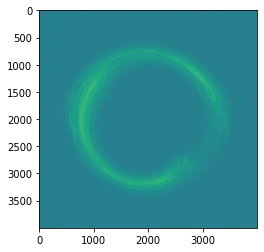

In [14]:
plt.imshow( tracer.trace.nodes['image']['value'] )

In [15]:
keys = OBSTRACE.nodes.keys()
for k in keys: print(k,  OBSTRACE.nodes[k]['value'] )

ext/gamma_1 0.007
ext/gamma_2 0.01
main/phi 1.0
main/q 0.75
main/r_ein 1.5
main/slope 2.1
main/x -0.05
main/y 0.1
Xsrc tensor([[-1.5191, -1.5181, -1.5171,  ...,  1.4799,  1.4809,  1.4820],
        [-1.5188, -1.5178, -1.5168,  ...,  1.4796,  1.4807,  1.4817],
        [-1.5185, -1.5175, -1.5166,  ...,  1.4794,  1.4804,  1.4815],
        ...,
        [-1.4582, -1.4571, -1.4561,  ...,  1.4488,  1.4498,  1.4508],
        [-1.4584, -1.4574, -1.4563,  ...,  1.4491,  1.4501,  1.4511],
        [-1.4587, -1.4576, -1.4566,  ...,  1.4494,  1.4504,  1.4514]])
Ysrc tensor([[-1.5670, -1.5667, -1.5664,  ..., -1.5658, -1.5661, -1.5663],
        [-1.5659, -1.5657, -1.5654,  ..., -1.5648, -1.5650, -1.5652],
        [-1.5649, -1.5646, -1.5643,  ..., -1.5637, -1.5639, -1.5642],
        ...,
        [ 1.5756,  1.5753,  1.5751,  ...,  1.6289,  1.6292,  1.6295],
        [ 1.5767,  1.5764,  1.5761,  ...,  1.6299,  1.6302,  1.6304],
        [ 1.5777,  1.5775,  1.5772,  ...,  1.6309,  1.6311,  1.6314]])
mu tenso

Observation with lens parameters that are random drawn from distributions

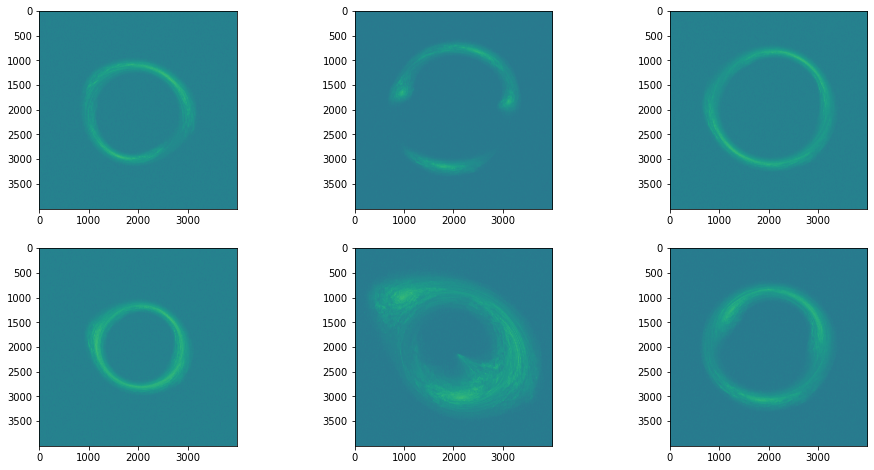

In [16]:
plot_mult([model() for _ in range(6)], 2)

`OBS` = `data['obs']` observation with noise

`data['mu']` observation without noise

`Xsrc` & `Ysrc` displacement fields / deflection fields, see `SPLELens/Lensbase/_deflection`

source + `Xsrc` = observation, see `pyrofit/mode/raytrace` (line 95): `self.X - alpha is source - Xsrc`

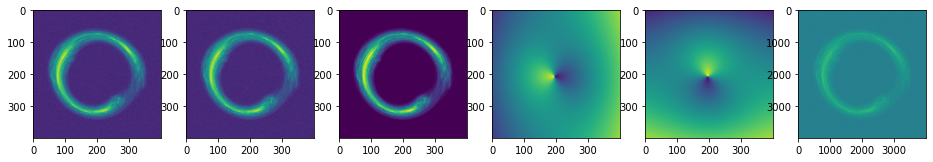

In [17]:
plots = [OBS, data['obs'], data['mu'], data['Xsrc'], data['Ysrc'], OBSTRACE.nodes['image']['value']]
plot_mult(plots, 1)

In [18]:
# Restore coarse grid
model.coerce_XY(X, Y)
model.mask = MASK
model.stochastic_specs['sigma_stat'] /= UPSAMPLE

#### Show mock observation

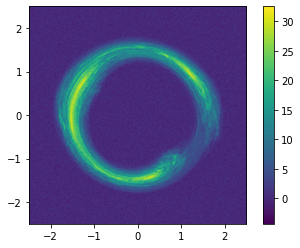

In [19]:
plt.imshow(np.ma.array(data=OBS, mask=False), **imkwargs)
plt.colorbar()

#### Make a mask

42009 unmasked pixels (26.255624771118164% of image)
S/N: 2039.5699462890625


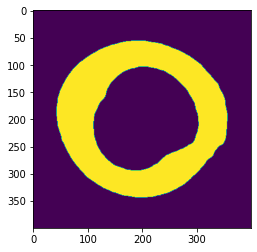

In [20]:
# Generate mask
model.mask = MASK = torch.tensor(get_mask(OBS, sigma=3., th=1.), dtype=bool)
print(f"{MASK.sum()} unmasked pixels ({MASK.sum().float() / MASK.numel() * 100}% of image)")
snr = (MASK * OBS).sum() / (NOISE * np.sqrt(MASK.sum().float()))
print(f"S/N: {snr}")

plt.imshow(MASK)

#### Save everything

In [21]:
os.path.join(BASEDIR, f"mock_sigma_stat=1.pt")

'ngc4414/mock_sigma_stat=1.pt'

In [22]:
torch.save(data, os.path.join(BASEDIR, f"mock_sigma_stat=1.pt"))
np.save(os.path.join(BASEDIR, f"mask.npy"), MASK)

# Plot Lens

In [23]:
from pyrofit.lensing.lenses import *

In [24]:
lenses = ['PointMassLens', 'GaussianLens', 'NFWLens', 'TrueTruncatedNFWLens', 'JaffeLens', 'SimonasJaffeLens', 'SPLELens', 'SPLELens2', 'ExternalShear', ]

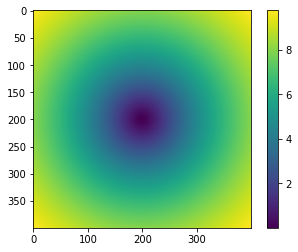

In [25]:
nfw = NFWLens(0.5, 2)
plt.imshow( nfw._m(torch.sqrt( X**2 + Y**2 )) )
plt.colorbar()

# Adding lens light

In [26]:
from pyrofit.lensing.sources import SersicSource

In [27]:
sersic = SersicSource()

In [28]:
lens =  sersic(X,Y, x = 0.3, y = 0.1, phi = 0., q = 1., index = 1., r_e = 1., I_e = 5.)

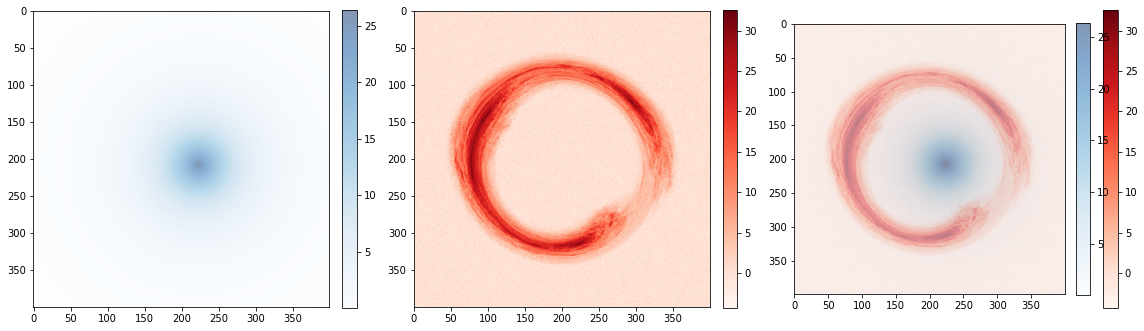

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8))

for ax in [ax2, ax3]:
    im = ax.imshow(OBS, cmap = 'Reds')
    fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)

for ax in [ax1, ax3]:
    im = ax.imshow(lens, alpha = 0.5, cmap = 'Blues')
    fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)

plt.tight_layout()
plt.show()

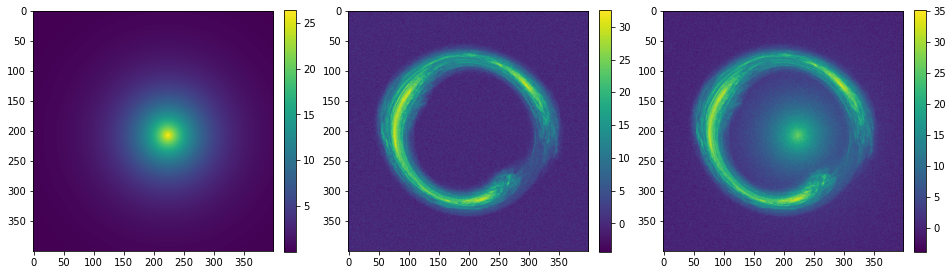

In [30]:
plot_mult([lens, OBS, OBS + lens], colorbar = True)

#### Creating Mask and savring everything

84296 unmasked pixels (52.68499755859375% of image)
S/N: 1446.844970703125


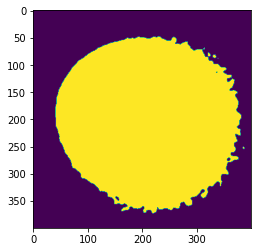

In [31]:
# Generate mask
model.mask = MASK = torch.tensor(get_mask(OBS + lens, sigma=3., th=1.), dtype=bool)
print(f"{MASK.sum()} unmasked pixels ({MASK.sum().float() / MASK.numel() * 100}% of image)")
snr = (MASK * OBS).sum() / (NOISE * np.sqrt(MASK.sum().float()))
print(f"S/N: {snr}")

plt.imshow(MASK)

In [32]:
# torch.save(OBS, os.path.join(BASEDIR, 'OBS.pt'))
# torch.save(lens, os.path.join(BASEDIR, 'lens.pt'))

In [33]:
# torch.save(data, os.path.join(BASEDIR, f"mock_sigma_stat=1.pt"))
# np.save(os.path.join(BASEDIR, f"mask.npy"), MASK)